# 시계열 분석
- 온도, 습도, 기압, 풍향 등 14개 데이터 사용, 10분마다 기록
- 며칠간의 데이터를 입력하고 24시간 이후의 기온 예측

## 드롭아웃, 스태킹, 양방향 순환신경망 사용
- 순환 드롭아웃: 과대적합을 방지
- 스태킹 순환 층: 네트워크의 표현능력을 향상(계산량은 늘어난다)
- 양방향 순환 층: 서로 다른 방향으로 데이터를 입력하여 정확도를 높이고 기억을 오랫동안 유지  

## 데이터
- 독일 Jena시 막스 프랑크 생물지구화학연구소에서 지상 관측소에서 측정한 데이터 
- 2009~2016년 데이터 사용

## 교수님 사이트 : https://blog.naver.com/ojunny62

In [ ]:
- (참고) https://codingalzi.github.io/dlp2/dl_for_timeseries.html

In [3]:
import numpy as np
import pandas as pd
import os, os.path, shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget --no-check-certificate \
    https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip \
    -O jena_climate.zip

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [10]:
!unzip jena_climate.zip

Archive:  jena_climate.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  


In [4]:
!ls

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [5]:
# 데이터프레임으로 읽는 경우
df = pd.read_csv('jena_climate_2009_2016.csv')
df[:3]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


In [6]:
x = df.drop('Date Time', axis=1).values
x[:3]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02]])

In [7]:
# data_dir = './data'
# fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# csv 파일을 직접 다루는 경우
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print("데이터 사이즈: ",len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
데이터 사이즈:  420551


In [8]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

- enumerate()
    - 반복문 사용 시 몇 번째 반복문인지 확인이 필요할 수 있습니다. 이때 사용
    - 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환

In [14]:
x = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    x[i, :] = values

In [15]:
x[:3]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02],
       [ 9.96570e+02, -8.41000e+00,  2.65010e+02, -9.28000e+00,
         9.34000e+01,  3.23000e+00,  3.02000e+00,  2.10000e-01,
         1.89000e+00,  3.03000e+00,  1.30980e+03,  7.20000e-01,
         1.50000e+00,  1.36100e+02],
       [ 9.96530e+02, -8.51000e+00,  2.64910e+02, -9.31000e+00,
         9.39000e+01,  3.21000e+00,  3.01000e+00,  2.00000e-01,
         1.88000e+00,  3.02000e+00,  1.31024e+03,  1.90000e-01,
         6.30000e-01,  1.71600e+02]])

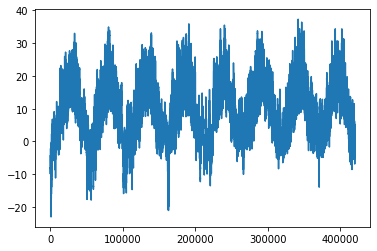

In [16]:
temp = x[:, 1]  # 기온만 그려본다
plt.plot(range(len(temp)), temp)
plt.show()

### 10일간 데이터
- 샘플은 10분마다 측정
- 스케일링 필요 (데이터 속성이 다름)
- 하루에 140번 측정

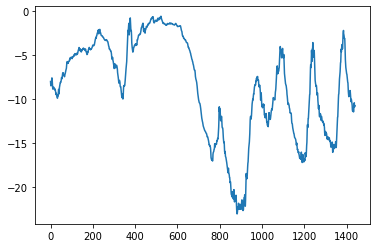

In [17]:
plt.plot(range(1440), temp[:1440])
plt.show()

## 파라미터 준비


* `lookback = 1440`, 10일간 데이터를 관찰.
* `steps = 6`, 1시간마다 한번 샘플링.
* `delay = 144`, 24시간 후를 예측.

### 준비할 사항

- 데이터 변환 (스케일링): 20만개 훈련 샘플을 사용하여 평균과 표준편차를 계산한다.
- 데이터가 수치형이므로 벡터화는 사용하지 않는다
- 입력 데이터와 레이블을 공급하기 위한 제너레이터를 작성



In [20]:
mean = x[:200000].mean(axis=0)
x -= mean
std = x[:200000].std(axis=0)
x /= std

In [21]:
std, mean

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([ 2.35142852e-12, -6.28273600e-15,  7.46772859e-13, -1.21087956e-14,
         2.42951509e-14,  4.34444314e-15, -6.97213176e-15, -1.16579003e-14,
         2.78895790e-14,  7.98244804e-16, -1.30972425e-13,  1.37250925e-14,
        -5.88101390e-14, -2.93813751e-15]))

제너레이터는 (samples, targets) 형태의 값을 생성한다.  sample은 입력의 한 배치를 나타낸다.

제너레이터를 사용하는 이유는 입력 데이터를 모두 한번에 메모리에 미리 로드하지 않기 위해서이다.

아래는 제너레이터 함수의 인자이다:

* `data`: 스케링된 입력 데이터
* `lookback`: 과거의 몇개의 타임스텝을 사용할지 지정
* `delay`: 미래 몇 타임스텝후를 예측할지
* `min_index` and `max_index`: 검증 및 테스트 데이터를 구분하는 경계를 표시
* `shuffle`: 샘플들은 랜덤하게 취할지를 지정
* `batch_size`: 배치 크기
* `step`: 샘플 데이터를 취할 타임스텝수 (여기서는 6)

In [22]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

훈련 데이터는 처음 20만개, 검증 데이터는 다음 10만개, 나머지는 테스트 데이터로 사용한다.
SGD를 사용하면 과적합을 피하고, 최적값을 찾아낸 확률이 높아진다.

In [23]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(x,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(x,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(x,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(x) - 300001 - lookback) // batch_size

## 기본 성능 모델

평균치 예측 등, 가장 기본적인 성능을 내는, 최소 기준의 모델을 말한다. 기계학습을 사용하면 적어도 이보다는 성능이 좋아야 한다.
  
여기서는 내일의 날씨는 오늘과 같다고 단순히 예측하는 모델을 사용하겠다. 성능 평가로 절대값 오차를 사용(MAE). 

- 아래에 기본 성능 모델의 성능을 계산하였다.

In [24]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.28973597299053566


- 오차 값 0.29 : 정규화한 값
- 실제 온도의 오차 : 정규화한 오차 값 * 표준 편차(8.8525) 
    - 온도의 평균 오차 : 2.57˚C 

## 간단한 신경망 모델

- 여기서는 두개의 전결합망으로 구성된 MLP을 먼저 만들어보겠다. 성능평가는 MAE를 사용한다.회귀문제이므로 마지막 단은 활성화함수를 사용하지 않는다.

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, x.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 19s 38ms/step - loss: 1.4610 - val_loss: 1.0730
Epoch 2/20
500/500 [==============================] - 19s 37ms/step - loss: 0.5063 - val_loss: 0.2974
Epoch 3/20
500/500 [==============================] - 19s 38ms/step - loss: 0.3028 - val_loss: 0.2467
Epoch 4/20
500/500 [==============================] - 19s 37ms/step - loss: 0.2720 - val_loss: 0.2384
Epoch 5/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2567 - val_loss: 0.1697
Epoch 6/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2473 - val_loss: 0.2219
Epoch 7/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2396 - val_loss: 0.2121
Epoch 8/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2344 - val_loss: 0.2355
Epoch 9/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2293 - val_loss: 0.2175
Epoch 10/20
500/500 [==============================] - 19s 37ms/step - loss: 0.22

훈련과 검증 데이터에 대해서 손실함수 그래프를 그려보겠다.

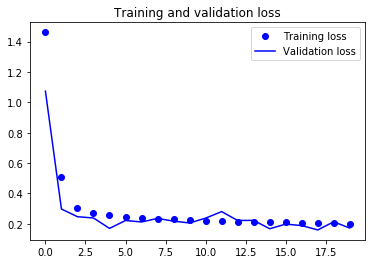

In [28]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

앞에서 구한 기본성능 0.29을 얻는 것도 쉽지 않다. 모델로 복잡한 구조를 사용했다고 해서 간단한, 상식적인 모델보다 우수한 성능을 내는 것은 아니다. 모델이 이러한 답을 바로 찾을 수 있다는 보장은 없다. (사람의 직관에 의한 기본 성능을 내는 것도 컴퓨터에게는 어려울 수 있다.)

## 간단한 RNN 모델

앞의 MLP는 시간 정보를 활용하지 못하고 있다. 시퀀스 데이터를 그대로 사용하고 이를 반영하는 모델을 만들어야 한다. 

LSTM을 간략히 구현하는 방식인 GRU(gated recurrent unit)을 사용하겠다.

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 140s 280ms/step - loss: 0.3046 - val_loss: 0.3055
Epoch 2/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2826 - val_loss: 0.3328
Epoch 3/20
500/500 [==============================] - 150s 300ms/step - loss: 0.2773 - val_loss: 0.3216
Epoch 4/20
500/500 [==============================] - 168s 335ms/step - loss: 0.2716 - val_loss: 0.3151
Epoch 5/20
500/500 [==============================] - 172s 343ms/step - loss: 0.2652 - val_loss: 0.3265
Epoch 6/20
500/500 [==============================] - 158s 316ms/step - loss: 0.2599 - val_loss: 0.3266
Epoch 7/20
500/500 [==============================] - 155s 311ms/step - loss: 0.2567 - val_loss: 0.3322
Epoch 8/20
500/500 [==============================] - 156s 312ms/step - loss: 0.2537 - val_loss: 0.3351
Epoch 9/20
500/500 [==============================] - 163s 327ms/step - loss: 0.2489 - val_loss: 0.3631
Epoch 10/20
500/500 [==============================] - 169s 339m

[링크 텍스트](https://)아래 결과를 보면 성능이 나아졌다.

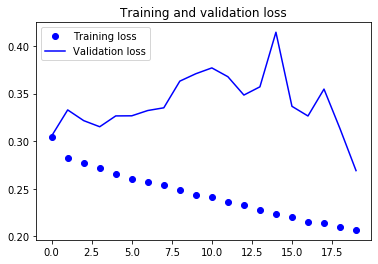

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

MAE 성능이 0.265 정도로 조금 개선되었다.(2.35˚C)  - 기본 모델의 성능이 2.57˚C 였다.

## 과대적합 줄이기

몇 번의 이포크 후에 성능이 바빠지므로 과대적합된 것을 알 수 있다. 오랫동안 순환층 이전에 드롭아웃을 사용하면 학습에 방해가 된다고 알려졌다. 타임 스텝마다 랜덤하게 드롭아웃 패턴을 바꾸지 않고, 동일한 패턴을 모든 타임 스텝에 적용해야 한다. 드롭아웃을 사용하면 학습시간이 오래걸린다.


In [33]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, x.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
 29/500 [>.............................] - ETA: 1:58 - loss: nan

KeyboardInterrupt: 

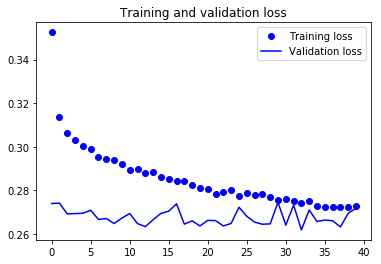

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

과대적합이 발생하지 않았다. 성능은 별로 개선되지는 않았다.

## 순환망 쌓기 (Stacking)

이제 과대적합이 되기 전까지는 네트워크의 복잡도(용량)을 늘려서 성능을 개선할 수 있다. 스태킹을 하려면 중간 계층에서는 시퀀스 전체를 출력해야 한다. 이를 위해서 return_sequences=True 로 설정해야 한다.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, x.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 346s - loss: 0.3341 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 344s - loss: 0.3125 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 344s - loss: 0.3045 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 344s - loss: 0.3018 - val_loss: 0.2747
Epoch 5/40
500/500 [==============================] - 344s - loss: 0.2957 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 344s - loss: 0.2923 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 344s - loss: 0.2907 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 343s - loss: 0.2879 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 343s - loss: 0.2866 - val_loss: 0.2743
Epoch 10/40
500/500 [==============================] - 344s - loss: 0.2833 - val_loss: 0.2669
Epoch 11/40
500/500 [==============================] - 344s - loss: 0

성능을 보겠다.

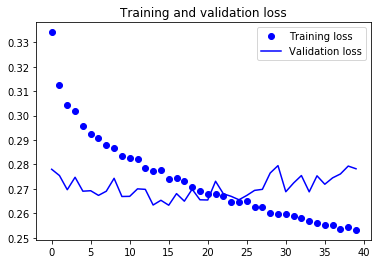

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가해도 성능이 크게 향상되지 않는 것을 알 수 있다.

## 양방향 RNN

자연어 처리에서 우수한 성능을 낸다. RNN을 두개 사용하고 입력 시퀀스를 역방향으로도 사용한 두가지 학습하여 이를 합친다. 이를 통해 단방향이 놓치지 쉬운 패턴을 찾아낼 수 있다.

아래와 같이 '순서를 뒤집는' 유명한 코드를 사용한다.

`yield samples[:, ::-1, :], targets`


온도 예측의 경우, 성능은 오히려 나빠지는 것을 알 수 있다. - 자연어 처리에서는 성능이 개선되는 경우가 많다 (최근 BERT)

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 172s - loss: 0.4781 - val_loss: 0.4797
Epoch 2/20
500/500 [==============================] - 171s - loss: 0.4529 - val_loss: 0.4679
Epoch 3/20
500/500 [==============================] - 170s - loss: 0.4071 - val_loss: 0.4536
Epoch 4/20
500/500 [==============================] - 171s - loss: 0.3670 - val_loss: 0.4398
Epoch 5/20
500/500 [==============================] - 170s - loss: 0.3343 - val_loss: 0.4320
Epoch 6/20
500/500 [==============================] - 170s - loss: 0.3191 - val_loss: 0.4388
Epoch 7/20
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.4186
Epoch 8/20
500/500 [==============================] - 170s - loss: 0.2938 - val_loss: 0.4014
Epoch 9/20
500/500 [==============================] - 170s - loss: 0.2824 - val_loss: 0.4077
Epoch 10/20
500/500 [==============================] - 170s - loss: 0.2724 - val_loss: 0.4090
Epoch 11/20
500/500 [==============================] - 170s - loss: 0

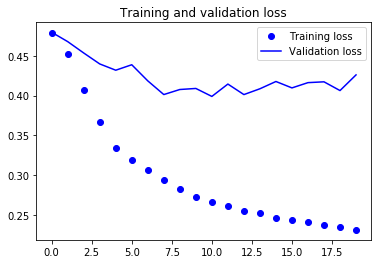

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()